In [67]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from datetime import datetime
from pprint import pprint

#Crimes_2012-2015
#https://catalog.data.gov/dataset/crimes-2012-2015

# 935259 Rows
# 2012 - 2015
#Header = Date.Rptd, DR.NO,DATE.OCC,TIME.OCC,AREA,AREA.NAME,RD,Crm.Cd,CrmCd.Desc,Status,Status.Desc,
#            LOCATION,Cross.Street,Location.1
#AREA.NAME = districten


years =[]

#import dataset (pas locatie aan)
#filter header eruit
crime_data = (sc.textFile('../data/crimesLA/Crimes_2012-2015.csv').filter(lambda line: 'DATE.OCC' not in line))

year12 = crime_data.filter(lambda line: '/2012'  in line)
year13 = crime_data.filter(lambda line: '/2013'  in line)
year14 = crime_data.filter(lambda line: '/2014'  in line)
year15 = crime_data.filter(lambda line: '/2015'  in line)

years.append(year12)
years.append(year13)
years.append(year14)
years.append(year15)



In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

# x_axis = [ for i in range(12, 16, 1)]

x_axis = [2012, 2013, 2014, 2015]
y_axis = []

for i in range(0, 4):
    y_axis.append(years[i].count())
    print years[i].count()




238117
239731
240449
228443


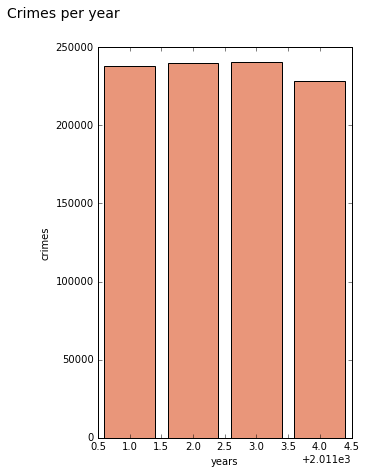

In [80]:
fig = plt.figure(figsize=(10, 7))
fig.suptitle('Crimes per year', fontsize=14)
ax = fig.add_subplot(122)
ax.set_xlabel('years')
ax.set_ylabel('crimes')
ax.bar(x_axis, y_axis, fc='darksalmon', align='center')
plt.show()

In [82]:
# from pyspark.sql import SQLContext
# from pyspark.sql.types import *
# from datetime import datetime

# #Crimes_2012-2015
# #https://catalog.data.gov/dataset/crimes-2012-2015

# # 935259 Rows
# # 2012 - 2015
# #Header = Date.Rptd, DR.NO,DATE.OCC,TIME.OCC,AREA,AREA.NAME,RD,Crm.Cd,CrmCd.Desc,Status,Status.Desc,
# #            LOCATION,Cross.Street,Location.1
# #AREA.NAME = districten

# YEARS = [2012, 2013, 2014, 2015]
# crime_data = []

# #import dataset (pas locatie aan)
# #filter header eruit
# # crime_data = (sc.textFile('../data/crimesLA/Crimes_2012-2015.csv').filter(lambda l: 'DATE.OCC' not in l))

# # convert to a dataframe
# def convert_to_df(year):
# #     if year == '2015-01':
# #         separator = '\t'
# #     else:
# #         separator = ';'
#     seperator = ";"
#     crime_data = sc.textFile('../Crimes_2012-2015.csv')
#     year_rdd = (crime_data
#                     .filter(lambda l: 'DATE.OCC' not in l)
#                     .filter(lambda l: '/' + year in l)
#                     .map(lambda l: add_fields(l, separator))
#                )
    
#     # apply the schema to the RDD.
#     year_df = sqlContext.createDataFrame(year_rdd, schema)
    
#     return year_df

# fields = []
# fields.append(StructField('DateReported', DateType(), True))
# fields.append(StructField('Docnr', IntegerType(), True))
# fields.append(StructField('DateOccupied', DateType(), True))
# fields.append(StructField('areaId', IntegerType(), True))
# fields.append(StructField('areaName', StringType(), True))
# fields.append(StructField('rd', IntegerType(), True))
# fields.append(StructField('crimeId', IntegerType(), True))
# fields.append(StructField('crimeName', StringType(), True))
# fields.append(StructField('statusId', IntegerType(), True))
# fields.append(StructField('statusName', StringType(), True))
# fields.append(StructField('location', StringType(), True))
# fields.append(StructField('crossStreet', StringType(), True))
# fields.append(StructField('location_type', StringType(), True))
# schema = StructType(fields)


        

# fields = []
# fields.append(StructField('DateReported', DateType(), True))
# fields.append(StructField('Docnr', IntegerType(), True))
# fields.append(StructField('DateOccupied', DateType(), True))
# fields.append(StructField('areaId', IntegerType(), True))
# fields.append(StructField('areaName', StringType(), True))
# fields.append(StructField('rd', IntegerType(), True))
# fields.append(StructField('crimeId', IntegerType(), True))
# fields.append(StructField('crimeName', StringType(), True))
# fields.append(StructField('statusId', IntegerType(), True))
# fields.append(StructField('statusName', StringType(), True))
# fields.append(StructField('location', StringType(), True))
# fields.append(StructField('crossStreet', StringType(), True))
# fields.append(StructField('lat', FloatType(), True))
# fields.append(StructField('long', FloatType(), True))
# schema = StructType(fields)




# def add_fields(line, separator):
#     fields = []
#     vals = line.split(separator)
#     # DateReported
#     date = datetime.strptime(vals[0], '%m/%d/%Y')
#     fields.append(date)
#     # Docnr
#     fields.append(int(vals[2]))
#     # DateOccupied
#     date = datetime.strptime(vals[3], '%m/%d/%Y')
#     fields.append(date)
#     # areaId
#     fields.append(int(vals[4]))
#     # areaName
#     fields.append(vals[3])
#     # rd
#     fields.append(int(vals[5]))
#     # crimeId
#     fields.append(int(vals[6]))
#     # crimeName
#     fields.append(vals[7])
#     # statusId
#     fields.append(int(vals[8]))
#     # statusName
#     fields.append(vals[9])
#     # location
#     fields.append(vals[10])
#     # crossStreet
#     fields.append(vals[11])
#     # lat
#     fields.append(vals[12][2:])
#     # longit
#     fields.append(vals[12][:-2])
    
    
#     return fields
# zz